In [1]:
import os
# NOTE: material: https://drive.google.com/drive/u/0/folders/14J6oWZzULqtXfIv99064Cs0iHVdeat22

In [2]:
# NOTE: access to directory
dir_project = os.path.abspath(".")
print(f"{dir_project=}")
os.chdir(dir_project)
print(f"{os.getcwd()=}")

dir_project='/root/Documents/Projects/augmented_safeguard/D-NeRF'
os.getcwd()='/root/Documents/Projects/augmented_safeguard/D-NeRF'


In [3]:

import json
import math
import time

import cv2
import imageio
import lpips
import numpy as np
import torch
torch.autograd.set_detect_anomaly(True)
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import mcubes
import trimesh
from tqdm import tqdm, trange


In [4]:
# NOTE: extended `config_parser()`

import NeRF.config_parser

def config_parser():
    import argparse
    parser = NeRF.config_parser.config_parser()

    # NOTE: D-NeRF training options
    # ------------------------------------------
    parser.add_argument("--nerf_type", type=str, default="original", help="nerf network type")
    parser.add_argument("--N_iter", type=int, default=500000, help="num training iterations")
    parser.add_argument("--do_half_precision", action="store_true", help="do half precision training and inference")

    parser.add_argument("--add_tv_loss", action="store_true", help="evaluate tv loss")
    parser.add_argument("--tv_loss_weight", type=float, default=1.e-4, help="weight of tv loss")
    # ------------------------------------------
    
    # NOTE: D-NeRF rendering options
    # ------------------------------------------
    parser.add_argument("--not_zero_canonical", action="store_true", help="if set zero time is not the canonic space")
    parser.add_argument("--use_two_models_for_fine", action="store_true", help="use two models for fine results")
    # ------------------------------------------

    return parser

In [5]:
# NOTE: parse arguments & load config
parser = config_parser()
filename_config = "configs/mutant.txt"
configs = NeRF.config_parser.load_config(parser, filename_config)
print(configs)

{'expname': 'mutant', 'basedir': './logs', 'datadir': './data/mutant', 'dataset_type': 'blender', 'nerf_type': 'direct_temporal', 'no_batching': 'True', 'not_zero_canonical': 'False', 'use_viewdirs': 'True', 'white_bkgd': 'True', 'lrate_decay': '500', 'N_iter': '800000', 'N_samples': '64', 'N_importance': '128', 'N_rand': '500', 'testskip': '1', 'precrop_iters': '500', 'precrop_iters_time': '100000', 'precrop_frac': '0.5', 'half_res': 'True', 'do_half_precision': 'False'}


In [6]:
# NOTE: assign configs to arguments

args = parser.parse_args(args=[])
args.config = filename_config
args.expname = configs['expname']
args.basedir = configs['basedir']
args.datadir = configs['datadir']
args.dataset_type = configs['dataset_type']

args.nerf_type = configs['nerf_type']
args.no_batching = configs['no_batching']
args.not_zero_canonical = configs['not_zero_canonical']

args.use_viewdirs = configs['use_viewdirs']
args.white_bkgd = configs['white_bkgd']
args.lrate_decay = int(configs['lrate_decay'])

args.N_iter = int(configs['N_iter'])
args.N_samples = int(configs['N_samples'])
args.N_importance = int(configs['N_importance'])
args.N_rand = int(configs['N_rand'])
args.testskip = int(configs['testskip'])

args.precrop_iters = int(configs['precrop_iters'])
args.precrop_iters_time = int(configs['precrop_iters_time'])
args.precrop_frac = float(configs['precrop_frac'])

args.half_res = bool(configs['half_res'])
args.do_half_precision = configs['do_half_precision']

args.no_reload = True # NOTE: for now set to True as we'll implement training code

print(args)

device = torch.device("cuda")
DEBUG=False
print(device)

torch.set_default_tensor_type('torch.cuda.FloatTensor')

Namespace(N_importance=128, N_iter=800000, N_rand=500, N_samples=64, add_tv_loss=False, basedir='./logs', chunk=32768, config='configs/mutant.txt', datadir='./data/mutant', dataset_type='blender', do_half_precision='False', expname='mutant', factor=8, ft_path=None, half_res=True, i_embed=0, i_img=500, i_print=100, i_testset=50000, i_video=50000, i_weights=10000, lindisp=False, llffhold=8, lrate=0.0005, lrate_decay=500, multires=10, multires_views=4, nerf_type='direct_temporal', netchunk=65536, netdepth=8, netdepth_fine=8, netwidth=256, netwidth_fine=256, no_batching='True', no_ndc=False, no_reload=True, not_zero_canonical='False', perturb=1.0, precrop_frac=0.5, precrop_iters=500, precrop_iters_time=100000, raw_noise_std=0.0, render_factor=0, render_only=False, render_test=False, shape='greek', spherify=False, testskip=1, tv_loss_weight=0.0001, use_two_models_for_fine=False, use_viewdirs='True', white_bkgd='True')
cuda


### Visualize Dataset

In [7]:
_datadir = "./data/mutant/"

with open(os.path.join(_datadir, "transforms_test.json"), "r") as fp:
    meta = json.load(fp)

print(str(meta)[:300])

_frames = meta['frames']
_frame = _frames[0]
print(_frame)

_fname = os.path.join(_datadir, _frame['file_path'] + ".png")
print(_fname)

import imageio.v2 as imageio
img = imageio.imread(_fname) # [800, 800, 4 = RGB+mask(synthetic; from Blender)]
print(img.shape)

{'camera_angle_x': 0.6911112070083618, 'frames': [{'file_path': './test/r_000', 'rotation': 0.3141592653589793, 'time': 0.0, 'transform_matrix': [[-0.9671632051467896, 0.0898933932185173, -0.23772795498371124, -0.958311915397644], [-0.254156231880188, -0.3420792818069458, 0.904647171497345, 3.646749
{'file_path': './test/r_000', 'rotation': 0.3141592653589793, 'time': 0.0, 'transform_matrix': [[-0.9671632051467896, 0.0898933932185173, -0.23772795498371124, -0.958311915397644], [-0.254156231880188, -0.3420792818069458, 0.904647171497345, 3.6467490196228027], [-7.450581485102248e-09, 0.9353613257408142, 0.35369348526000977, 1.4257838726043701], [0.0, 0.0, 0.0, 1.0]]}
./data/mutant/./test/r_000.png
(800, 800, 4)


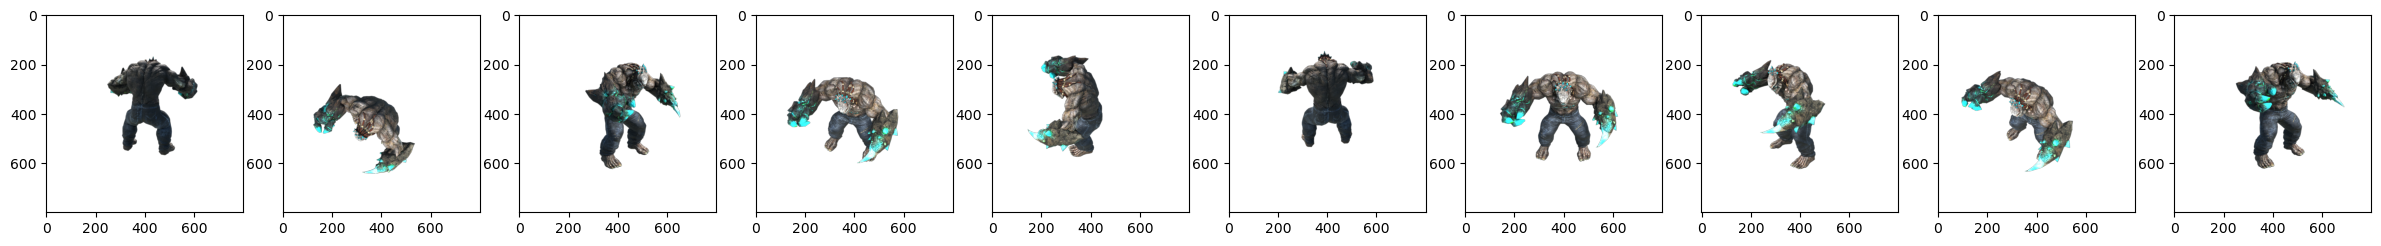

In [8]:
# NOTE: sequential visualization

fig, axis = plt.subplots(1, 10, figsize=(30, 300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)

    axis[i].imshow(img)

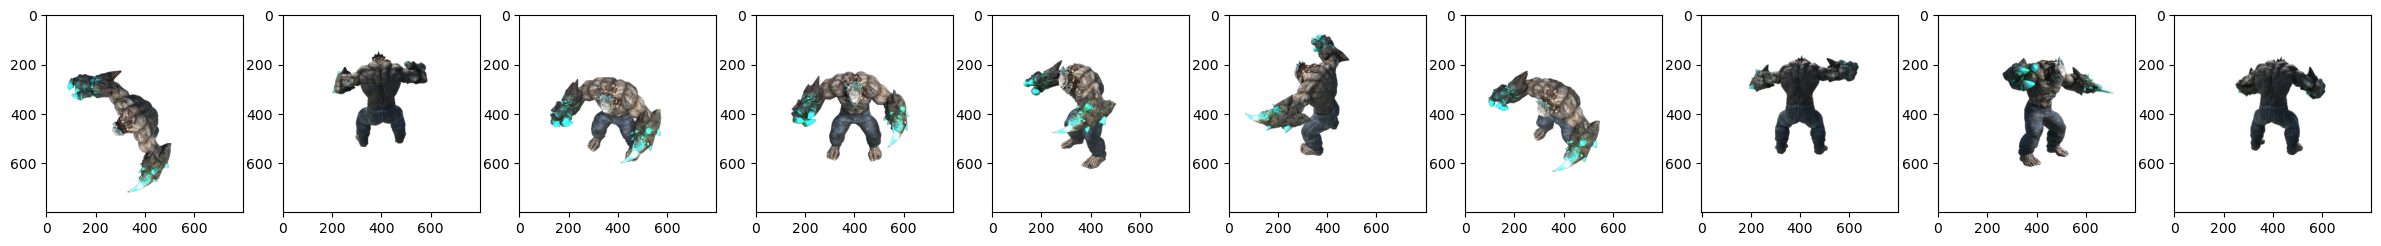

In [9]:
# NOTE: random shuffled visualization

import random
random.shuffle(_frames)
fig, axis = plt.subplots(1, 10, figsize=(30, 300))
for i in range(10):
    _frame = _frames[i]
    _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

    img = imageio.imread(_fname)

    axis[i].imshow(img)

In [10]:
# NOTE: decomposed channel visualization

# NOTE: blocked here to prevent manipulation of original data
if False: 
    imgs = []
    for i in range(10):
        _frame = _frames[i]
        _fname = os.path.join(_datadir, _frame["file_path"] + ".png")

        img = imageio.imread(_fname)
        imgs.append(img)

    imgs = (np.array(imgs) / 255.0).astype(np.float32) # [0., 1.]
    print(imgs.shape)

    imgs_orig = imgs[..., :3] # RGB
    imgs_mask = imgs[..., -1] # mask

    fig, axis = plt.subplots(1, 3)
    axis[0].imshow(imgs_orig[0])
    axis[1].imshow(imgs_mask[0], cmap="gray")

    # NOTE: how plt operates with mask
    imgs = imgs[..., :3] * imgs[..., -1:] + (1-imgs[..., -1:]) # `-1:`: broadcast 
    axis[2].imshow(imgs[0])

In [11]:
# NOTE: load blender data

import NeRF.dataloader
import NeRF.pose

# NOTE: implement Blender data loader
def load_blender_data(basedir, half_res: bool=False, testskip=1):

    """
    NOTE: if D-NeRF extended, marked as # as a suffix
    """

    images, poses, render_poses, hwf, i_split = NeRF.dataloader.load_blender_data(basedir, half_res, testskip)

    splits = ["train", "val", "test"]
    metas = {}

    # NOTE: load poses
    for s in splits:
        with open(os.path.join(basedir, f"transforms_{s}.json"), "r") as fp:
            metas[s] = json.load(fp)

    all_times = [] #

    for s in splits:
        meta = metas[s]
        times = [] # 
        skip = testskip # # NOTE: `time` should be re-normalized based on this

        for t, frame in enumerate(meta['frames'][::skip]):
            times.append(
                (cur_time := frame['time'] if 'time' in frame else float(t) / (len(meta['frames'][::skip]) - 1))
            ) #

        assert times[0] == 0, "Time must start at 0" # 

        times = np.array(times).astype(np.float32) #
        all_times.append(times) #

    times = np.concatenate(all_times, 0) #

    # assert poses.shape == times.shape

    path_transforms_render = os.path.join(basedir, "transforms_render.json")
    if os.path.exists(path_transforms_render):
        
        with open(path_transforms_render, "r") as fp:
            meta = json.load(fp)
        
        render_poses = []
        for frame in meta["frames"]:
            render_poses.append(np.array(frame["transform_matrix"]))
        render_poses = np.array(render_poses).astype(np.float32)

    else:
        render_poses = torch.stack(
            [
                NeRF.pose.pose_spherical(theta=angle, phi=-30.0, radius=4.0) 
                for angle
                in np.linspace(-180, 180, 160+1)[:-1]
            ], dim=0
        )
    render_times = torch.linspace(0.0, 1.0, render_poses.shape[0])

    return images, poses, times, render_poses, render_times, hwf, i_split


In [12]:
# NOTE: validation: load_blender_data
images, poses, times, render_poses, render_times, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)

# print(f"{i_split=}")
# print(f"{times=}")


print(f"{images.shape=}")
print(f"{poses.shape=}")
print(f"{times.shape=}")

print(poses[0])

images.shape=(190, 400, 400, 4)
poses.shape=(190, 4, 4)
times.shape=(190,)
[[ 8.8652200e-01 -3.0261922e-01  3.5000047e-01  1.4108970e+00]
 [ 4.6268642e-01  5.7982814e-01 -6.7061210e-01 -2.7033238e+00]
 [-1.4901161e-08  7.5645274e-01  6.5404826e-01  2.6365528e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


In [13]:
# NOTE: positional encoding

import NeRF.embedder

def get_embedder(multires, input_dims, i=0):
    if i == -1:
        return nn.Identity(), input_dims
    
    embed_kwargs = {
                'include_input' : True,
                'input_dims' : input_dims,
                'max_freq_log2' : multires-1,
                'num_freqs' : multires,
                'log_sampling' : True,
                'periodic_funcs' : [torch.sin, torch.cos],
    }

    embedder_obj = NeRF.embedder.Embedder(**embed_kwargs)
    embed = lambda x, eo=embedder_obj : eo.embed(x)

    return embed, embedder_obj.out_dim

In [14]:
# NOTE: model
import torch.nn as nn

import NeRF.model

class NeRFOriginal(NeRF.model.NeRF):
    """
    
    Canonical network
    """
    def __init__(
            self, 
            D=8, 
            W=256, 
            input_ch=3, 
            input_ch_views=3, 
            output_ch=4, 
            skips=[4], 
            use_viewdirs=False, 

            input_ch_time=1,
            memory=[], 
            embed_fn=None, 
            output_color_ch=3, 
            zero_canonical=True) -> None:
        super(NeRFOriginal, self).__init__(D, W, input_ch, input_ch_views, output_ch, skips, use_viewdirs)

        layers = [nn.Linear(input_ch, W)]
        for i in range(D-1):
            layer = nn.Linear

            in_channels = W
            if i in skips:
                in_channels += input_ch

            layers += [layer(in_channels, W)]

        self.pts_linears = nn.ModuleList(layers)
        self.views_linears = nn.ModuleList([nn.Linear(input_ch_views+W, W//2)])

        if use_viewdirs:
            self.feature_linear = nn.Linear(W, W)
            self.alpha_linear = nn.Linear(W, 1)
            self.rgb_linear = nn.Linear(W//2, output_color_ch)
        else:
            # NOTE: unused?
            self.output_linear = nn.Linear(W, output_ch)

    def forward(self, x, ts):

        input_pts, input_views = torch.split(
            x, 
            [self.input_ch, self.input_ch_views], dim=-1
        )
        h = input_pts

        for idx, _ in enumerate(self.pts_linears):
            h = self.pts_linears[idx](h)
            h = F.relu(h)

            if idx in self.skips:
                h = torch.cat([input_pts, h], dim=-1)

        if self.use_viewdirs:
            alpha = self.alpha_linear(h)
            feature = self.feature_linear(h)
            h = torch.cat([feature, input_views], dim=-1)

            for idx, _ in enumerate(self.views_linears):
                h = self.views_linears[idx](h)
                h = F.relu(h)

            rgb = self.rgb_linear(h)
            outputs = torch.cat([rgb, alpha], dim=-1)

        else:
            outputs = self.output_linear(h)

        return outputs, torch.zeros_like(input_pts[:, :3]) # NOTE: for compatibility with Deformation network


# NOTE: here both Deformation network and Canonical network is implemented
class DirectTemporalNeRF(nn.Module):
    def __init__(self, 
                 D=8, 
                 W=256, 
                 input_ch=3,
                 input_ch_views=3, 
                 input_ch_time=1, 
                 output_ch=4, 
                 skips=[4], 
                 use_viewdirs=False, 
                 memory=[],
                 embed_fn=None, 
                 zero_canonical=True
                 ) -> None:
        super().__init__()

        # NOTE: from vanilla NeRF
        self.D = D
        self.W = W
        self.input_ch = input_ch
        self.input_ch_views = input_ch_views
        self.skips = skips
        self.use_viewdirs = use_viewdirs

        # NOTE: D-NeRF
        self.input_ch_time = input_ch_time
        self.memory = memory
        self.embed_fn = embed_fn
        self.zero_canonical = zero_canonical

        # NOTE: Canonical network is vanilla NeRF
        self._occ = NeRFOriginal(
            D=D, 
            W=W, 
            input_ch=input_ch,
            input_ch_views=input_ch_views,
            input_ch_time=input_ch_time,
            output_ch=output_ch,
            skips=skips,
            use_viewdirs=use_viewdirs,
            memory=memory,
            embed_fn=embed_fn,
            output_color_ch=3
        )

        # NOTE: Deformation network
        self._time, self._time_out = self.create_time_net()

        return
    
    def create_time_net(self):
        """
        ### DirectTemporalNeRF.create_time_net()

        Encoded (position, time) => delta transformation from Canonical space
        """

        layers = [
            nn.Linear(self.input_ch + self.input_ch_time, self.W)
        ]
        for i in range(self.D - 1):
            layer = nn.Linear

            in_channels = self.W
            if i in self.skips:
                in_channels += self.input_ch # NOTE: skip connection
            
            layers += [layer(in_channels, self.W)]

        return (deformation_network := nn.ModuleList(layers)), (final_deformation_layer := nn.Linear(self.W, 3))
    
    def query_time(self, new_pts, t, net, net_final):
        """
        ### DirectTemporalNeRF.query_time

        Inference Deformation network

        Encoded (position, time) => delta transformation from Canonical space

        Arguments:
        - new_pts: chunked batch samples
        - t: time, dimension is same as `new_pts`
        """

        h = torch.cat([new_pts, t], dim=-1)

        for i, l in enumerate(net):
            h = net[i](h)
            h = F.relu(h)

            if i in self.skips:
                h = torch.cat([new_pts, h], dim=-1)

        # NOTE: final layer
        return net_final(h)

    def forward(self, x, ts):

        input_pts, input_views = torch.split(
            x, 
            [self.input_ch, self.input_ch_views], 
            dim=-1
        )
        t = ts[0]
        assert len(torch.unique(t[:, :1])) == 1, "Only accepts all points from same time"

        cur_time = t[0, 0] # NOTE: any index have equivalent value
        if cur_time == 0.0 and self.zero_canonical:
            dx = torch.zeros_like(input_pts[:, :3])
        else:
            dx = self.query_time(
                input_pts, 
                t, 
                self._time, 
                self._time_out
            ) # NOTE: deformation network
            input_pts_orig = input_pts[:, :3] # NOTE: drop direction; but was it already dropped by torch.split?

            # NOTE: re-embed with delta transformations
            input_pts = self.embed_fn(input_pts_orig + dx) 

        # NOTE: infer canonical network
        out, _ = self._occ(
            torch.cat([input_pts, input_views], dim=-1), 
            t # NOTE: `t` is unused
        )

        return out, dx
    
class NeRFWrapper:
    @staticmethod
    def get_by_name(type, *args, **kwargs):
        print(f"NeRF type selected: {type}")

        if type == "original":
            model = NeRFOriginal(*args, **kwargs)
        elif type == "direct_temporal":
            model = DirectTemporalNeRF(*args, **kwargs)
        else:
            raise ValueError(f"Type {type} not recognized.")
        
        return model


In [15]:
# NOTE: evaluate networks

import NeRF.model

def batchify(fn, chunk):

    if chunk is None:
        return fn
    
    def ret(inputs_pos, inputs_time):
        num_batches = inputs_pos.shape[0]

        out_list = []
        dx_list = []
        for i in range(0, num_batches, chunk):
            out, dx = fn(inputs_pos[i:i+chunk], [inputs_time[0][i:i+chunk], inputs_time[1][i:i+chunk]])
            out_list += [out]
            dx_list += [dx]

        return torch.cat(out_list, dim=0), torch.cat(dx_list, dim=0)
    
    return ret

def run_network(
    inputs, 
    viewdirs, 
    frame_time, 
    fn, 
    embed_fn, 
    embeddirs_fn, 
    embedtime_fn, 
    netchunk=1024*64, 
    embd_time_discr=True
):
    
    assert len(torch.unique(frame_time)) == 1, "Only accepts all points from same time"


    if embd_time_discr:
        B, N, _ = inputs.shape
        input_frame_time = frame_time[:, None].expand([B, N, 1])
        input_frame_time_flat = torch.reshape(input_frame_time, [-1, 1])
        embedded_time = embedtime_fn(input_frame_time_flat)
        embedded_times = [embedded_time, embedded_time]
    else:
        assert NotImplementedError

    embedded = NeRF.model.embed(inputs, viewdirs, embed_fn, embeddirs_fn)

    outputs_flat, position_delta_flat = batchify(fn, netchunk)(embedded, embedded_times)
    outputs = torch.reshape(outputs_flat, list(inputs.shape[:-1]) + [outputs_flat.shape[-1]])
    position_delta = torch.reshape(position_delta_flat, list(inputs.shape[:-1]) + [position_delta_flat.shape[-1]])

    return outputs, position_delta


def create_D_NeRF(args):

    # NOTE: `input_ch`: dimension of embedded positions
    embed_fn, input_ch = get_embedder(args.multires, 3, args.i_embed)

    input_ch_views = 0
    embeddirs_fn = None
    if args.use_viewdirs:
        # NOTE: `input_ch_views`: dimension of embedded directions
        embeddirs_fn, input_ch_views = get_embedder(args.multires_views, 3, args.i_embed)

    embedtime_fn, input_ch_time = get_embedder(args.multires, 1, args.i_embed)

    output_ch = 5 if args.N_importance > 0 else 4
    skips = [4]
    model = NeRFWrapper.get_by_name(
        args.nerf_type, 
        D=args.netdepth, 
        W=args.netwidth, 
        input_ch=input_ch, 
        output_ch=output_ch, 
        skips=skips,
        input_ch_views=input_ch_views,
        input_ch_time=input_ch_time, 
        use_viewdirs=args.use_viewdirs,
        embed_fn=embed_fn, 
        zero_canonical=not args.not_zero_canonical
    ).to(device)
    grad_vars = list(model.parameters())

    model_fine = None
    if args.use_two_models_for_fine:
        model_fine = NeRFWrapper.get_by_name(
            args.nerf_type, 
            D=args.netdepth_fine, 
            W=args.netwidth_fine,
            input_ch=input_ch, 
            output_ch=output_ch, 
            skips=skips,
            input_ch_views=input_ch_views,
            input_ch_time=input_ch_time,
            use_viewdirs=args.use_viewdirs,
            embed_fn=embed_fn, 
            zero_canonical=not args.not_zero_canonical,
        ).to(device)
        grad_vars += list(model_fine.parameters())

    # NOTE: helper function to running network
    network_query_fn = lambda inputs, viewdirs, ts, network_fn: run_network(
        inputs, 
        viewdirs, 
        ts, 
        network_fn, 
        embed_fn=embed_fn, 
        embeddirs_fn=embeddirs_fn, 
        embedtime_fn=embedtime_fn, 
        netchunk=args.netchunk, 
        embd_time_discr=args.nerf_type != "temporal"
    )

    # NOTE: create optimizer
    optimizer = torch.optim.Adam(params=grad_vars, lr=args.lrate, betas=(0.9, 0.999))
    '''
    if args.do_half_precision:
        print("Run model at half precision")
        if model_fine is not None:
            [model, model_fine], optimizers = amp.initialize([model, model_fine], optimizer, opt_level='O1')
        else:
            model, optimizers = amp.initialize(model, optimizer, opt_level='O1')
    '''

    start = 0
    basedir = args.basedir
    expname = args.expname

    
    ##########################
    # NOTE: Load checkpoints
    if args.ft_path is not None and args.ft_path!='None':
        ckpts = [args.ft_path]
    else:
        ckpts = [os.path.join(basedir, expname, f) for f in sorted(os.listdir(os.path.join(basedir, expname))) if 'tar' in f]

    print('Found ckpts', ckpts)
    if len(ckpts) > 0 and not args.no_reload:
        ckpt_path = ckpts[-1]
        print('Reloading from', ckpt_path)
        ckpt = torch.load(ckpt_path)

        start = ckpt['global_step']
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])

        # Load model
        model.load_state_dict(ckpt['network_fn_state_dict'])
        if model_fine is not None:
            model_fine.load_state_dict(ckpt['network_fine_state_dict'])
        print(f'Loaded from {ckpt_path}')
    ##########################

    render_kwargs_train = {
        'network_query_fn' : network_query_fn,
        'perturb' : args.perturb,
        'N_importance' : args.N_importance,
        'network_fine': model_fine,
        'N_samples' : args.N_samples,
        'network_fn' : model,
        'use_viewdirs' : args.use_viewdirs,
        'white_bkgd' : args.white_bkgd,
        'raw_noise_std' : args.raw_noise_std,
        'use_two_models_for_fine' : args.use_two_models_for_fine,
    }

    # NDC only good for LLFF-style forward facing data
    if args.dataset_type != 'llff' or args.no_ndc:
        render_kwargs_train['ndc'] = False
        render_kwargs_train['lindisp'] = args.lindisp

    render_kwargs_test = {k : render_kwargs_train[k] for k in render_kwargs_train}
    render_kwargs_test['perturb'] = False
    render_kwargs_test['raw_noise_std'] = 0.0

    return render_kwargs_train, render_kwargs_test, start, grad_vars, optimizer



In [16]:
# NOTE: rendering

from typing import Dict
import NeRF.ops
import NeRF.rendering
import NeRF.sampler

def render_rays_D(
    ray_batch, 
    network_fn, 
    network_query_fn, 
    N_samples, 
    retraw=False, 
    lindisp=False, 
    perturb=0.0, 
    N_importance=0, 
    network_fine=None, 
    white_bkgd=False, 
    raw_noise_std=0.0, 
    verbose=False, 
    pytest=False, 
    z_vals=None, 
    use_two_models_for_fine=False
):
    def __stability_check(ret: Dict):
        if False: # TODO: add DEBUG
            return
        for key, tensor in ret.items():
            if torch.isnan(tensor).any():
                pass
                # print(f"[ERROR] Numerical error! {key=} contains NaN.")
            if torch.isinf(tensor).any():
                pass
                # print(f"[ERROR] Numerical error! {key=} contains INF.")

    rays_o, rays_d, viewdirs, near, far, frame_time = NeRF.rendering.decompose_ray_batch(ray_batch, is_time_included=True)
    N_rays = ray_batch.shape[0]
    z_samples = None
    rgb_map_0, disp_map_0, acc_map_0, position_delta_0 = None, None, None, None

    if z_vals is None:
        z_vals = NeRF.rendering.sample_z(near, far, N_samples, lindisp)
        z_vals = z_vals.expand([N_rays, N_samples])
        z_vals = NeRF.rendering.add_noise_z(z_vals, perturb, pytest)

        pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]

        if N_importance <= 0: # NOTE: coarse network only
            raw, position_delta = network_query_fn(pts, viewdirs, frame_time, network_fn)
            rgb_map, disp_map, acc_map, weights, _ = NeRF.rendering.raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest)
        else: # NOTE: coarse + fine network
            if use_two_models_for_fine:
                raw, position_delta_0 = network_query_fn(pts, viewdirs, frame_time, network_fn)
                rgb_map_0, disp_map_0, acc_map_0, weights, _ = NeRF.rendering.raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest)
            else:
                with torch.no_grad():
                    raw, _ = network_query_fn(pts, viewdirs, frame_time, network_fn)
                    _, _, _, weights, _ = NeRF.rendering.raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest)

            # NOTE: importance sampling
            z_vals_mid = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
            z_importance_samples = NeRF.sampler.sample_pdf(
                z_vals_mid, 
                weights[..., 1:-1], 
                N_importance, 
                det=(perturb == 0.0), 
                pytest=pytest
            )
            z_importance_samples = z_importance_samples.detach()

            # NOTE: aggregate importance samples
            z_vals, __IDX_NO_NEED = torch.sort(
                torch.cat([z_vals, z_importance_samples], dim=-1),
                dim=-1
            )

    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
    run_fn = network_fn if network_fine is None else network_fine
    raw, position_delta = network_query_fn(pts, viewdirs, frame_time, run_fn)
    rgb_map, disp_map, acc_map, weights, _ = NeRF.rendering.raw2outputs(raw, z_vals, rays_d, raw_noise_std, white_bkgd, pytest)

    ret = {'rgb_map' : rgb_map, 'disp_map' : disp_map, 'acc_map' : acc_map, 'z_vals' : z_vals,
           'position_delta' : position_delta}
    if retraw:
        ret['raw'] = raw
    if N_importance > 0:
        if rgb_map_0 is not None:
            ret['rgb0'] = rgb_map_0
        if disp_map_0 is not None:
            ret['disp0'] = disp_map_0
        if acc_map_0 is not None:
            ret['acc0'] = acc_map_0
        if position_delta_0 is not None:
            ret['position_delta_0'] = position_delta_0
        if z_samples is not None:
            ret['z_std'] = torch.std(z_samples, dim=-1, unbiased=False)  # [N_rays]

    __stability_check(ret)
    
    return ret

def render_path(
    render_poses, 
    render_times, 
    hwf, 
    chunk, 
    render_kwargs, 
    gt_imgs=None, 
    savedir=None, 
    render_factor=0,
    save_also_gt=False,
    i_offset=0
):
    
    # NOTE: similar with NeRF.rendering.render_path

    H, W, focal = hwf
    if render_factor > 0:
        H = H // render_factor
        W = W // render_factor
        focal = focal / render_factor

    if savedir is not None:
        save_dir_estim = os.path.join(savedir, "estim")
        save_dir_gt = os.path.join(savedir, "gt")
        os.makedirs(save_dir_estim, exist_ok=True)
        os.makedirs(save_dir_gt, exist_ok=True)

    rgbs, disps, accs = [], [], []

    for i, (c2w, frame_time) in enumerate(zip(tqdm(render_poses), render_times)):
        rgb, disp, acc, _ = render(
            H, W, focal, 
            chunk=chunk, c2w=c2w[:3, :4], 
            frame_time=frame_time, 
            **render_kwargs
        )

        rgbs.append(rgb.cpu().numpy())
        disps.append(disp.cpu().numpy())
        accs.append(acc.cpu().numpy())

        if savedir is not None:
            rgb8_estim = NeRF.ops.to_8b(rgbs[-1])
            imageio.imwrite(os.path.join(save_dir_estim, f"{i+i_offset:03d}.png"), rgb8_estim)

            if save_also_gt:
                rgb8_gt = NeRF.ops.to_8b(gt_imgs[i])
                imageio.imwrite(os.path.join(save_dir_gt, f"{i+i_offset:03d}.png"), rgb8_gt)

    return np.stack(rgbs, 0), np.stack(disps, 0), np.stack(accs, 0)

def render(
    H, 
    W, 
    focal, 
    chunk=32*1024, 
    rays=None, 
    c2w=None, 
    ndc=True, 
    near=0.0, 
    far=1.0, 
    frame_time=None, 
    use_viewdirs=False, 
    c2w_staticcam=None, 
    **kwargs
):
    
    K = np.array([
        [focal, 0, 0.5 * W], 
        [0, focal, 0.5 * H], 
        [0, 0, 1]
    ])

    rays_o, rays_d, near, far, viewdirs, rays_original_shape = NeRF.rendering.prepare_rays(H, W, K, rays, c2w, ndc, near, far, use_viewdirs, c2w_staticcam)

    frame_time = frame_time * torch.ones_like(rays_d[..., :1])
    rays = torch.cat([rays_o, rays_d, near, far, frame_time], dim=-1) # TODO: wrapping function that returns `rays`, as we can concat frame_time
    if use_viewdirs:
        rays = torch.cat([rays, viewdirs], dim=-1)

    ret_list, ret_dict = NeRF.rendering.images_from_rendering(rays, chunk, render_rays_D, rays_original_shape, **kwargs)

    return ret_list + [ret_dict]

In [17]:
# NOTE: training

import NeRF.trainer

def train(args):

    # NOTE: load data
    # NOTE: NeRF on dynamic scene: hard; until 2022 it was limited to faces e.g., HyperNeRF, NeRFace etc
    if args.dataset_type == "blender":
        images, poses, times, render_poses, render_times, hwf, i_split = load_blender_data(args.datadir, args.half_res, args.testskip)

        i_train, i_val, i_test, near, far, images = NeRF.dataloader.post_load_blender_data(i_split, images, args.white_bkgd)

    else:
        raise KeyError(f"[ERROR] unknown {args.dataset_type=}! Exiting...")
    
    min_time, max_time = times[i_train[0]], times[i_train[-1]]
    assert min_time == 0.0, f"[ERROR] {min_time=} must start at 0"
    assert max_time == 1.0, f"[ERROR] {max_time=} must be 1"

    H, W, focal = hwf
    H, W = int(H), int(W)
    hwf = [H, W, focal]
    K = np.array([
        [focal, 0, 0.5 * W], 
        [0, focal, 0.5 * H], 
        [0, 0, 1]
    ])

    
    basedir = args.basedir
    expname = args.expname
    NeRF.trainer.save_args_and_config(basedir, expname, args)

    if args.render_test:
        render_poses = np.array(poses[i_test])
        render_times = np.array(times[i_test])
    render_poses = torch.Tensor(render_poses).to(device)
    render_times = torch.Tensor(render_times).to(device)

    # NOTE: create NeRF model
    render_train_kwargs, render_test_kwargs, global_step, grad_vars, optimizer = NeRF.trainer.initialize_NeRF(create_D_NeRF, near, far, args)

    # TODO: separate from `train`; this is only an inference function!
    if args.render_only:
        test_save_dir = os.path.join(basedir, expname, f"render_only_{'test' if args.is_render_test else 'path'}_{global_step:06d}")
        os.makedirs(test_save_dir, exist_ok=True)

        rgbs, _, _ = render_path(
            render_poses, 
            render_times, 
            hwf, 
            args.chunk,
            render_test_kwargs, 
            gt_imgs=images[i_test] if args.render_test else None,
            savedir=test_save_dir,
            render_factor=args.render_factor,
            save_also_gt=False
        )

        imageio.mimwrite(
            os.path.join(test_save_dir, "video.mp4"), 
            NeRF.ops.to_8b(rgbs), fps=10, quality=8)
        print(f"[INFO ] Done render_only at {test_save_dir}")

        return
    
    N_rand = args.N_rand
    use_batching = not args.no_batching
    if use_batching:
        rays_rgb = NeRF.trainer.shuffle_rays(H, W, K, images, poses, i_train)
        i_batch = 0

    if use_batching:
        rays_rgb = torch.Tensor(rays_rgb).to(device)
    images = torch.Tensor(images).to(device)
    poses = torch.Tensor(poses).to(device)
    times = torch.Tensor(times).to(device)

    psnrs = []
    iternums = []
    N_iters = args.N_iter + 1

    start = global_step
    for i in trange(start, N_iters):
        time0 = time.time()

        if use_batching:
            # TODO: batching w/ time not implemented; do later
            raise NotImplementedError("Time not implemented") 

            # Random over all images
            batch = rays_rgb[i_batch:i_batch+N_rand] # [B, 2+1, 3*?]
            batch = torch.transpose(batch, 0, 1)
            batch_rays, target_s = batch[:2], batch[2]

            i_batch += N_rand
            if i_batch >= rays_rgb.shape[0]:
                print("Shuffle data after an epoch!")
                rand_idx = torch.randperm(rays_rgb.shape[0])
                rays_rgb = rays_rgb[rand_idx]
                i_batch = 0

        else: # NOTE: image batch
            if i >= args.precrop_iters_time:
                img_i = np.random.choice(i_train)
            else:
                skip_factor = i / float(args.precrop_iters_time) * len(i_train)
                max_sample = max(int(skip_factor), 3)
                img_i = np.random.choice(i_train[:max_sample])

            target = images[img_i]
            pose = poses[img_i, :3, :4]
            frame_time = times[img_i]

            if N_rand is not None:
                rays_o, rays_d = NeRF.rendering.get_rays(H, W, K, torch.Tensor(pose))

                # NOTE: for fast training
                if i < args.precrop_iters:
                    dH = int(H//2 * args.precrop_frac)
                    dW = int(W//2 * args.precrop_frac)

                    h_start = H//2 - dH
                    h_end = H//2 + dH - 1
                    h_steps = 2*dH 

                    w_start = W//2 - dW
                    w_end = W//2 + dW - 1
                    w_steps = 2*dW                   

                    if i == start:
                        print(f"[INFO ] center cropping of size {2*dH} x {2*dW}is enabled until iter {args.precrop_iters}")

                # NOTE: ray batch from all pixels
                else:
                    
                    h_start = 0
                    h_end = H - 1
                    h_steps = H

                    w_start = 0
                    w_end = W - 1
                    w_steps = W
                
                coords = torch.stack(
                    torch.meshgrid(
                        torch.linspace(h_start, h_end, h_steps), 
                        torch.linspace(w_start, w_end, w_steps)
                    ), dim=-1
                )

            coords = torch.reshape(coords, [-1, 2])
            select_coords = coords[
                np.random.choice(coords.shape[0], size=[N_rand], replace=False)
            ].long()

            batch_rays = torch.stack([
                rays_o[select_coords[:, 0], select_coords[:, 1]],
                rays_d[select_coords[:, 0], select_coords[:, 1]] 
            ], dim=0)

            # NOTE: GT pixels
            target_s = target[select_coords[:, 0], select_coords[:, 1]]

        # NOTE: optimization
        rgb, disp, acc, extras = render(
            H, W, focal, 
            chunk=args.chunk, 
            rays=batch_rays, 
            frame_time=frame_time, 
            verbose=i < 10, 
            retraw=True,
            **render_train_kwargs
        )

        # TODO: tv loss?? (unused?)
        # NOTE: loss calculation & backpropagation
        optimizer.zero_grad()
        img_loss_fine = NeRF.loss.image_to_MSE(
            output=rgb, 
            target=target_s
        )
        loss = img_loss_fine
        if "rgb0" in extras:
            img_loss_coarse = NeRF.loss.image_to_MSE(
                output=extras["rgb0"], 
                target=target_s
            )
            loss = loss + img_loss_coarse
        loss.backward()
        optimizer.step()

        # NOTE: PSNR for statistics
        psnr_fine = NeRF.metric.loss_to_PSNR(img_loss_fine)
        # psnr_coarse = NeRF.metric.loss_to_PSNR(img_loss_coarse) # NOTE: `img_loss_coarse` undefined

        # NOTE: learning rate update (sec. 5.3)
        decay_rate = 0.1
        decay_steps = args.lrate_decay * 1000
        new_lrate = args.lrate * (decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group["lr"] = new_lrate

        # NOTE: logging
        dt = time.time() - time0
        # NOTE: save checkpoints TODO: rename `args.i_weights`
        if i % args.i_weights == 0:
            path = os.path.join(basedir, expname, f"{i:06d}.tar")
            save_dict = {
                "global_step": global_step, 
                "network_fn_state_dict": render_train_kwargs["network_fn"].state_dict(), 
                "optimizer_state_dict": optimizer.state_dict(),
            }
            if render_train_kwargs["network_fine"] is not None:
                save_dict["network_fine_state_dict"] = render_train_kwargs["network_fine"].state_dict()

            torch.save(
                save_dict, f=path
            )

        if i % args.i_print == 0:
            tqdm.write(f"[INFO ] train; iter={global_step}, loss={loss.item()}, psnr={psnr_fine.item()}")

            # NOTE: render for plot
            img_i = np.random.choice(i_val)
            target = images[img_i]
            pose = poses[img_i, :3, :4]
            frame_time = times[img_i]
            with torch.no_grad():
                rgb, disp, acc, extras = render(
                    H, W, focal, 
                    chunk=args.chunk,
                    c2w=pose, 
                    frame_time=frame_time,
                    **render_test_kwargs
                )

            # NOTE: plotting
            psnrs.append(psnr_fine.detach().cpu().numpy())
            iternums.append(global_step)

            fig = plt.figure(figsize=(10, 4))
            ax1 = fig.add_subplot(1, 2, 1)
            ax1.imshow(rgb.cpu())
            ax1.set_title(f"Iteration: {global_step}")
            ax2 = fig.add_subplot(1, 2, 2)
            ax2.plot(iternums, psnrs)
            ax2.set_title(f"PSNR")
            fig.show() # TODO: check if this should be turned on; why not headless?

            # NOTE: save plot
            dir_iter_plot = os.path.join(basedir, expname, "iter_plots")
            os.makedirs(dir_iter_plot, exist_ok=True)
            fig.savefig(
                os.path.join(dir_iter_plot, f"iter={global_step}_PSNR={psnr_fine.item():.6f}.png")
            )

            fig.clear()
            plt.close(fig)

        # del loss, psnr_fine, target_s


        global_step += 1

    return

    

In [18]:
# NOTE: training

torch.set_default_tensor_type("torch.cuda.FloatTensor")

args.chunk = 1024 * 16
args.netchunk = 1024 * 32
args.i_print = 1000
args.no_reload = True
train(args)

NeRF type selected: direct_temporal
Found ckpts ['./logs/mutant/000000.tar', './logs/mutant/800000.tar']


  0%|          | 0/800001 [00:00<?, ?it/s]

[INFO ] center cropping of size 200 x 200is enabled until iter 500


/root/anaconda3/envs/augmented_safeguard/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402421473/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 0/800001 [00:00<?, ?it/s]

[INFO ] train; iter=0, loss=0.17583204805850983, psnr=7.549019813537598


/tmp/ipykernel_19590/4032614562.py:250: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() # TODO: check if this should be turned on; why not headless?
  0%|          | 1000/800001 [04:38<56:55:32,  3.90it/s]

[INFO ] train; iter=1000, loss=0.004111301153898239, psnr=23.860206604003906
